# Implicit Gradient Demo (ECG Imputation)


In [1]:
import os, sys, torch, numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.join(os.path.dirname('__file__'), '..'))
from src.config import CGConfig, LayerConfig
from src.layer import DiagOpLayer
from src.weights import WeightNet


In [2]:
def load_ecg_data():
    data_path = os.path.join(os.path.dirname('__file__'), '..', 'data', 'ecg_missing.txt')
    with open(data_path, 'r', encoding='utf-8') as f:
        vals = [float('nan') if (ln := line.strip()) == 'NaN' else float(ln) for line in f]
    x_full = torch.tensor(vals, dtype=torch.float32)
    unknown_idx = torch.where(torch.isnan(x_full))[0]
    x_true = x_full.clone()
    known = ~torch.isnan(x_full)
    if known.any():
        ki = torch.where(known)[0].numpy(); kv = x_full[ki].numpy(); mi = torch.where(~known)[0].numpy()
        if len(mi) > 0:
            x_true[~known] = torch.tensor(np.interp(mi, ki, kv), dtype=torch.float32)
    return x_full, unknown_idx, x_true

def create_features(x_full, unknown_idx):
    x_clean = torch.nan_to_num(x_full, nan=0.0)
    mean_val = x_clean.mean(); std_val = x_clean.std()
    pos = torch.zeros(len(x_full)); pos[unknown_idx] = 1.0
    return torch.cat([mean_val.unsqueeze(0), std_val.unsqueeze(0), pos])


In [3]:
x_full, unknown_idx, x_true = load_ecg_data()
n = len(x_full); m = n - 2
layer = DiagOpLayer(CGConfig(tol=1e-6, maxiter=1000, verbose=False), LayerConfig(mode='implicit', eps_w=1e-4))
net = WeightNet(input_dim=n+2, hidden_dims=[32,16], output_dim=m)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []
for epoch in range(10):
    opt.zero_grad(); feats = create_features(x_full, unknown_idx); u = net(feats.unsqueeze(0))
    out = layer(u, x_full.unsqueeze(0), unknown_idx)
    phi = out['phi'].sum(); v_loss = 0.5 * torch.sum(out['v']**2); loss = phi + v_loss
    losses.append(loss.item()); loss.backward(); opt.step()
losses[:3]


[4.975494861602783, 4.9597578048706055, 4.95772647857666]

In [4]:
with torch.no_grad():
    feats = create_features(x_full, unknown_idx); u = net(feats.unsqueeze(0))
    out = layer(u, x_full.unsqueeze(0), unknown_idx)
    v = out['v'].squeeze(0); x_rec = x_full.clone(); x_rec[unknown_idx] = v
err = torch.norm(x_rec - x_true).item(); err


0.14735040068626404

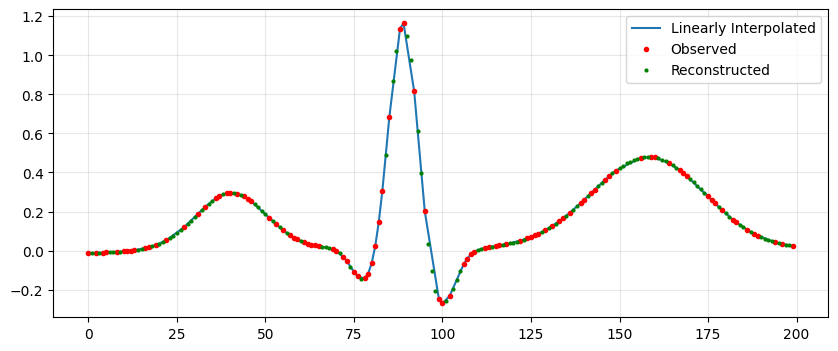

In [5]:
t = torch.arange(len(x_true))
plt.figure(figsize=(10,4))
plt.plot(t, x_true, label='Linearly Interpolated'); obs = ~torch.isnan(x_full)
plt.plot(t[obs], x_full[obs], 'ro', ms=3, label='Observed')
miss = torch.isnan(x_full); plt.plot(t[miss], x_rec[miss], 'g.', ms=4, label='Reconstructed')
plt.legend(); plt.grid(True, alpha=0.3)
